# Transient heat analysis of thermo-optic phase-shifters

This example demonstrates the usage of the Tidy3D's steady and unsteady heat analyses to compare the performances of thermo-optic phase-shifters based on TiN metal and N++ doped silicon in the silicon-on-insulator (SOI) platform, based on the paper [Optimization of thermo-optic phase-shifter design and mitigation of thermal crosstalk on the SOI platform
](https://opg.optica.org/oe/fulltext.cfm?uri=oe-27-8-10456&id=408126) by M. Jacques, A. Samani, E. El-Fiky, D. Patel, Z. Xing, and D. V. Plant.

The two setups compared are:
1) A silicon strip waveguide with a TiN metal heater layer above
3) A silicon rib waveguide with doped silicon strips on either side

For each design, we sweep various input heat powers to determine the power needed for a $\pi$ phase shift ($P_\pi$) in steady-state analysis. We then compare the times required to reach the steady-state results by running unsteady heat analyses with the required $P_\pi$ heats. Finally, we use the $P_\pi$ temperature profiles to optically perturb the structures and calculate the attenuations for both designs. At all stages, we achieve good agreement with the results of Jacques et. al.

<img src="img/transient_thermooptic.png" width="500" alt="Illustration of the thermo-optic phase shifter">

In [1]:
# Standard python imports
import matplotlib.pyplot as plt
import numpy as np

# Tidy3D import
import tidy3d as td
from tidy3d import web

## Simulation Construction and Heat Input Sweep

First we will determine which heat input results in a $\pi$ shift for the shifter by creating a sweep of simulations, each with different heat inputs, and calculating the resulting phase shift, following from Jacques et. al.

In [2]:
wvl0 = 1.55
freq0 = td.C_0 / wvl0

We define the dimensions and coordinates of the different structures involved in our simulations.

In [3]:
wg_width = 0.5
wg_height = 0.22

slab_height = 0.09
wg_buffer = 0.8
slab_width = wg_width + 2 * wg_buffer

doping_width = 1

heater_dist = 2
heater_height = wg_height + heater_dist
heater_width = 2
heater_thickness = 0.2

air_height = 2.5

box_thickness = 2

length = 320

sim_size = (40, 0, 18)

We define the geometries of the involved structures.

In [4]:
wg_geo = td.Box(center=(0, 0, wg_height / 2), size=(wg_width, length, wg_height))
heater_geo = td.Box(
    center=(0, 0, heater_height + heater_thickness / 2),
    size=(heater_width, length, heater_thickness),
)

rib_geo = td.Box(center=(0, 0, slab_height / 2), size=(slab_width, length, slab_height))
dope_L_geo = td.Box(
    center=((wg_width + doping_width) / 2 + wg_buffer, 0, slab_height / 2),
    size=(doping_width, length, slab_height),
)
dope_R_geo = td.Box(
    center=(-(wg_width + doping_width) / 2 - wg_buffer, 0, slab_height / 2),
    size=(doping_width, length, slab_height),
)

air_geo = td.Box.from_bounds(
    rmin=(-sim_size[0] / 2, -length / 2, air_height),
    rmax=(sim_size[0] / 2, length / 2, air_height + length),
)

box_geo = td.Box.from_bounds(
    rmin=(-sim_size[0] / 2, -length / 2, -box_thickness), rmax=(sim_size[0] / 2, length / 2, 0)
)
substrate_geo = td.Box.from_bounds(
    rmin=(-sim_size[0] / 2, -length / 2, -length),
    rmax=(sim_size[0] / 2, length / 2, -box_thickness),
)

We have geometries that extend exactly to the simulation boundaries, but since we will only be running heat simulations and mode solving, this will not cause any problems. Thus we will suppress warnings.

In [5]:
td.config.logging_level = "ERROR"

Using the material data provided in Table 3 of Jacques et. al., we define the materials as Tidy3D [`MultiPhysicsMediums`](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.components.material.multi_physics.MultiPhysicsMedium.html#tidy3d.components.material.multi_physics.MultiPhysicsMedium). In these objects, we can input heat, charge, and optical properties. Our heat properties are all Tidy3D [`SolidSpec`](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.SolidSpec.html#tidy3d.SolidSpec) specifications, and our optical properties are instances of Tidy3D's [`PerturbationMedium`](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.PerturbationMedium.html#tidy3d.PerturbationMedium) using the provided thermo-optic coefficients. Given temperature data, these mediums will have their optical properties changed by the perturbations specified in the `PerturbationMedium`.

In [6]:
ref_temp = 300
Si_dndT = 1.8e-4

Si_perturb_undoped = td.PerturbationMedium(
    permittivity=3.476**2,
    perturbation_spec=td.IndexPerturbation(
        delta_n=td.ParameterPerturbation(
            heat=td.LinearHeatPerturbation(coeff=Si_dndT, temperature_ref=ref_temp)
        ),
        freq=freq0,
    ),
)

n_doped, k_doped = 3.072, 0.137
Si_perturb_doped = Si_perturb_undoped.updated_copy(
    permittivity=n_doped**2 - k_doped**2,
    conductivity=2 * n_doped * k_doped * 2 * np.pi * freq0 * td.EPSILON_0,
)


SiO2_perturb = td.PerturbationMedium(
    permittivity=1.55**2,
    perturbation_spec=td.IndexPerturbation(
        delta_n=td.ParameterPerturbation(
            heat=td.LinearHeatPerturbation(coeff=1e-5, temperature_ref=ref_temp)
        ),
        freq=freq0,
    ),
)


Si_bulk = td.MultiPhysicsMedium(
    name="Si bulk",
    optical=Si_perturb_undoped,
    heat=td.SolidSpec(conductivity=148e-6, capacity=711, density=2330e-18),
)

Si_wg = td.MultiPhysicsMedium(
    name="Si wg",
    optical=Si_perturb_undoped,
    heat=td.SolidSpec(conductivity=90e-6, capacity=711, density=2330e-18),
)

Si_slab = td.MultiPhysicsMedium(
    name="Si slab",
    optical=Si_perturb_undoped,
    heat=td.SolidSpec(conductivity=55e-6, capacity=711, density=2330e-18),
)

N_Si = td.MultiPhysicsMedium(
    name="Si doped",
    optical=Si_perturb_doped,
    heat=td.SolidSpec(conductivity=25e-6, capacity=711, density=2330e-18),
)

SiO2 = td.MultiPhysicsMedium(
    name="SiO2",
    optical=SiO2_perturb,
    heat=td.SolidSpec(conductivity=1.38e-6, capacity=709, density=2203e-18),
)

TiN = td.MultiPhysicsMedium(
    name="TiN", heat=td.SolidSpec(conductivity=28e-6, capacity=598, density=5240e-18)
)

air_medium = td.MultiPhysicsMedium(
    name="air",
    heat=td.FluidSpec(thermal_conductivity=0.026e-6, specific_heat=1006, density=1.177e-18),
)

We put the geometries and mediums together in Tidy3D `Structure` objects.

In [7]:
wg = td.Structure(geometry=wg_geo, medium=Si_wg)
heater = td.Structure(geometry=heater_geo, medium=TiN, name="heater TiN")

rib = td.Structure(geometry=rib_geo, medium=Si_slab)
doped_wgs = td.Structure(geometry=dope_L_geo + dope_R_geo, medium=N_Si, name="heater doped")

air = td.Structure(geometry=air_geo, medium=air_medium)

box = td.Structure(geometry=box_geo, medium=SiO2)
substrate = td.Structure(geometry=substrate_geo, medium=Si_bulk)

We add our structures into a [`Scene`](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.Scene.html#tidy3d.Scene) object. This is a convenient way to package our structures and allows for easy conversion to HeatCharge simulations.

In [8]:
wg_scene = td.Scene(medium=SiO2, structures=[substrate, box, wg, air, heater])

rib_scene = td.Scene(medium=SiO2, structures=[substrate, box, rib, wg, air, doped_wgs])

We plot the scenes to make sure our structures are set up correctly.

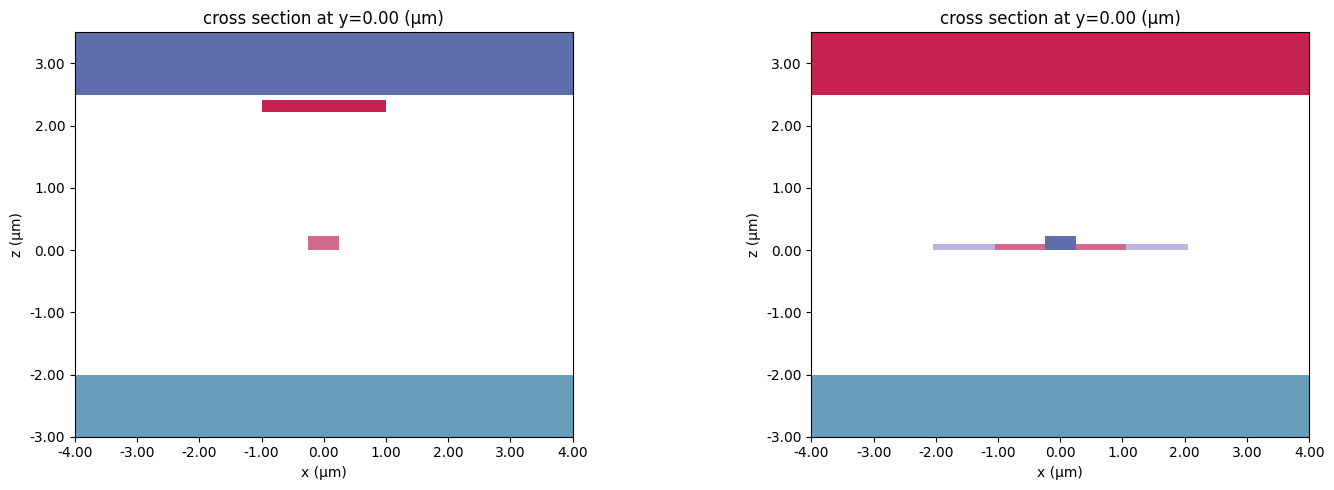

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

wg_scene.plot(y=0, hlim=[-4, 4], vlim=[-3, air_height + 1], ax=ax[0])
rib_scene.plot(y=0, hlim=[-4, 4], vlim=[-3, air_height + 1], ax=ax[1])
plt.tight_layout()
plt.show()

We will measure the temperature in the waveguide by a point temperature monitor located at the center of the waveguides.

In [10]:
temp_mnt_pnt = td.TemperatureMonitor(
    center=(0, 0, wg_height / 2),
    size=(0, 0, 0),
    name="temperature",
    unstructured=True,
    conformal=True,
)

We define boundary and meshing specs for our heat simulations. Jacques et. al. give the bottom simulation boundary a fixed temperature of 300 K and a constant convection of $10 \frac{W}{m^2}K$ (or $10e-12  \frac{W}{μm^2}K$) between the silicon dioxide cladding and air.

In [11]:
# boundary conditions
bc_bottom = td.HeatBoundarySpec(
    placement=td.SimulationBoundary(surfaces=["z-"]),
    condition=td.TemperatureBC(temperature=ref_temp),
)

bc_top = td.HeatBoundarySpec(
    placement=td.MediumMediumInterface(mediums=["air", "SiO2"]),
    condition=td.ConvectionBC(ambient_temperature=ref_temp, transfer_coeff=10e-12),  # W/um^2 K
)

# parameters for meshing
dl_min = heater_thickness / 3
dl_max = 4 * dl_min

grid_spec = td.DistanceUnstructuredGrid(
    dl_interface=dl_min,
    dl_bulk=dl_max,
    distance_interface=3 * dl_min,
    distance_bulk=2 * heater_dist,
)

We can now run a parameter sweep of different heat inputs to determine relationship between the input heat and the phase change along the shifter.
We will define functions that take as input the heater input power and output the heat simulations for the strip and rib waveguide structures, allowing us to quickly and methodically define multiple heat simulations corresponding to multiple heat inputs.

In [12]:
def make_wg_sim(power):  # input mW
    power_rate = power * 1e-3 / heater_geo.volume()
    heater_TiN = td.HeatSource(rate=power_rate, structures=[heater.name])
    wg_sim = td.HeatChargeSimulation.from_scene(
        scene=wg_scene,
        center=(0, 0, 1),
        size=sim_size,
        boundary_spec=[bc_bottom, bc_top],
        sources=[heater_TiN],
        monitors=[temp_mnt_pnt],
        symmetry=(1, 0, 0),
        grid_spec=grid_spec,
    )
    return wg_sim


def make_rib_sim(power):  # input mW
    power_rate = power * 1e-3 / doped_wgs.geometry.volume()
    heater_doped = td.HeatSource(rate=power_rate, structures=[doped_wgs.name])
    rib_sim = td.HeatChargeSimulation.from_scene(
        scene=rib_scene,
        center=(0, 0, 1),  # (0, 0, 5),
        size=sim_size,
        boundary_spec=[bc_bottom, bc_top],
        sources=[heater_doped],
        monitors=[temp_mnt_pnt],
        symmetry=(1, 0, 0),
        grid_spec=grid_spec,
    )
    return rib_sim

In [13]:
heater_sweep = np.linspace(0, 30, 5)

To create a batch, we will create a dictionary of simulations of the various heater rates.

In [14]:
initial_wg_sweep = {}
initial_rib_sweep = {}

for i, heat in enumerate(heater_sweep):
    initial_wg_sweep[str(i)] = make_wg_sim(heat)

for i, heat in enumerate(heater_sweep):
    heat_rate = heat
    initial_rib_sweep[str(i)] = make_rib_sim(heat)

We can now create and run the batches.

In [15]:
wg_batch = web.Batch(simulations=initial_wg_sweep, folder_name="thermo-optic_shifter")
rib_batch = web.Batch(simulations=initial_rib_sweep, folder_name="thermo-optic_shifter")

In [16]:
wg_batch_data = wg_batch.run(path_dir="thermo-optic_shifter")
rib_batch_data = rib_batch.run(path_dir="thermo-optic_shifter")

Output()

18:25:29 EDT Started working on Batch containing 5 tasks.

18:25:31 EDT Maximum FlexCredit cost: 0.125 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

18:25:33 EDT Batch complete.

Output()

Output()

18:25:36 EDT Started working on Batch containing 5 tasks.

18:25:39 EDT Maximum FlexCredit cost: 0.125 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

18:25:41 EDT Batch complete.

Output()

We now calculate the phase shift ($\Phi$) of the shifter based on the temperature recorded in the waveguide for each heat simulation:
<center>$\Delta\Phi=\frac{2\pi L}{\lambda_0}\frac{dn_{Si}}{dT}\Delta T$</center>

In [17]:
wg_ts, rib_ts = [], []
phases_wg, phases_rib = [], []

for i in range(len(heater_sweep)):
    coef = 2 * np.pi * length / wvl0 * Si_dndT

    t_wg = np.squeeze(wg_batch_data[str(i)]["temperature"].temperature.values) - ref_temp

    wg_ts.append(t_wg)
    phases_wg.append(coef * t_wg)

    t_rib = np.squeeze(rib_batch_data[str(i)]["temperature"].temperature.values) - ref_temp

    rib_ts.append(t_rib)
    phases_rib.append(coef * t_rib)

We plot the results of the heat sweep: calculated phase shift vs. the heat applied to the heaters. Interpolating these results gives us the needed heat source to achieve a $\pi$-shift in the shifter.

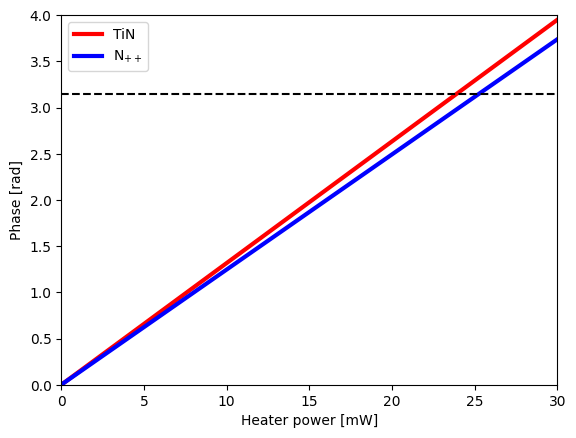

In [18]:
plt.plot(heater_sweep, phases_wg, label="TiN", color="red", linewidth=3)
plt.plot(heater_sweep, phases_rib, label="N$_{++}$", color="blue", linewidth=3)
plt.plot([heater_sweep[0], heater_sweep[-1]], [np.pi, np.pi], color="black", linestyle="--")
plt.legend()
plt.xlim(heater_sweep[0], heater_sweep[-1])
plt.ylim(0, 4)
plt.xlabel("Heater power [mW]")
plt.ylabel("Phase [rad]")
plt.show()

## $\pi$-shift Input Power

Now we will use the paper's calculated power values that need to be applied for a full $\pi$-shift ($P_\pi$). We wish to display the temperature distribution along a 2D section of the simulation, so we will define a new temperature monitor. We will then ultilize the above function to create the corresponding heat simulation.

In [19]:
wg_pi_shift = 23.9
rib_pi_shift = 25.2

# add 2D monitor to display 2D temperature distribution
temp_mnt_2D = td.TemperatureMonitor(
    center=(0, 0, 1), size=(30, 0, 4), name="temperature", unstructured=True, conformal=True
)

wg_sim = make_wg_sim(wg_pi_shift).updated_copy(monitors=[temp_mnt_2D])
rib_sim = make_rib_sim(rib_pi_shift).updated_copy(monitors=[temp_mnt_2D])

In [20]:
wg_data = web.run(wg_sim, task_name="wg", path="thermo-optic_shifter/wg.hdf5")
rib_data = web.run(rib_sim, task_name="rib", path="thermo-optic_shifter/rib.hdf5")

18:25:51 EDT Created task 'wg' with resource_id                                 
             'hec-d5ec8930-571d-4983-975a-5636bf196d34' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

18:25:52 EDT Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:25:53 EDT status = success

Output()

18:25:54 EDT loading simulation from thermo-optic_shifter/wg.hdf5

             Created task 'rib' with resource_id                                
             'hec-b90afcbb-b249-49eb-9b3d-d8c33d42efd5' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

18:25:55 EDT Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:25:56 EDT status = success

Output()

18:25:57 EDT loading simulation from thermo-optic_shifter/rib.hdf5

We will now plot the temperature distribution with the $P_\pi$ powers applied to the respective heaters of the simulation.

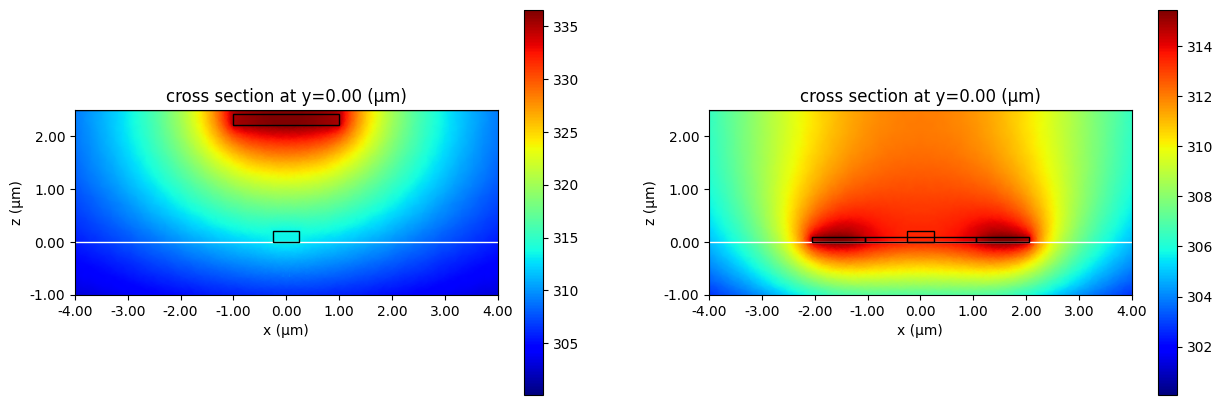

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
wg_data["temperature"].temperature.plot(grid=False, cmap="jet", ax=ax[0])
wg_data.simulation.plot_structures(y=0, fill=False, ax=ax[0])
rib_data["temperature"].temperature.plot(grid=False, cmap="jet", ax=ax[1])
rib_data.simulation.plot_structures(y=0, fill=False, ax=ax[1])
ax[0].set_xlim(-4, 4)
ax[0].set_ylim(-1, 2.5)
ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-1, 2.5)
plt.show()

We also plot the temperature profile as a function of distance from the center of the waveguides.

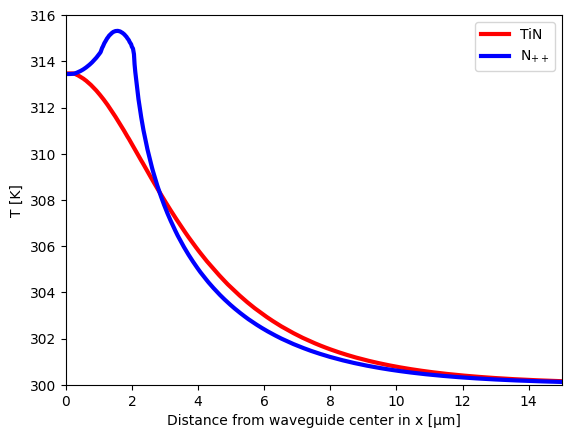

In [22]:
wg_line = (
    wg_data["temperature"].temperature.plane_slice(axis=2, pos=wg_height / 2).sel(x=slice(0, 15))
)
rib_line = (
    rib_data["temperature"].temperature.plane_slice(axis=2, pos=wg_height / 2).sel(x=slice(0, 15))
)

plt.plot(wg_line.x, np.squeeze(wg_line.values), label="TiN", color="red", linewidth=3)
plt.plot(rib_line.x, np.squeeze(rib_line.values), label="N$_{++}$", color="blue", linewidth=3)
plt.legend()
plt.xlim(0, 15)
plt.ylim(300, 316)
plt.xlabel("Distance from waveguide center in x [μm]")
plt.ylabel("T [K]")
plt.show()

## Transient Heat Simulation

The previous heat simulations were steady-state heat simulations. To determine the temperature profile starting from the reference temperature while the heater heats the simulation, we will need to define an [`UnsteadyHeatAnalysis`](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.UnsteadyHeatAnalysis.html#tidy3d.UnsteadyHeatAnalysis) spec to our heat simulation.
<br><br>
Our `UnsteadyHeatAnalysis` spec calculates the heat distribution at a set number of timesteps until it reaches the specified simulation time. The spec then takes as input the initial temperature, then an [`UnsteadySpec`](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.UnsteadySpec.html#tidy3d.UnsteadySpec) which specifies the length of time for each timestep in the analysis and the total simulation time.

In [23]:
heat_sim_time = 60e-6
heat_time_step = 1e-6

turn_on = td.UnsteadyHeatAnalysis(
    initial_temperature=ref_temp,
    unsteady_spec=td.UnsteadySpec(
        time_step=heat_time_step, total_time_steps=heat_sim_time / heat_time_step
    ),
)

Add the UnsteadyHeatAnalysis object to the heat simulation to make it a transient heat simulation.

In [24]:
wg_on = wg_sim.updated_copy(analysis_spec=turn_on)
rib_on = rib_sim.updated_copy(analysis_spec=turn_on)

In [25]:
wg_on_data = web.run(wg_on, task_name="wg on", path="thermo-optic_shifter/wg_on.hdf5")
rib_on_data = web.run(rib_on, task_name="rib on", path="thermo-optic_shifter/rib_on.hdf5")

18:25:58 EDT Created task 'wg on' with resource_id                              
             'hec-dde9e312-b850-41ff-b58c-77c735e9ea40' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

18:25:59 EDT Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             status = success

Output()

18:26:00 EDT loading simulation from thermo-optic_shifter/wg_on.hdf5

18:26:01 EDT Created task 'rib on' with resource_id                             
             'hec-430a348e-e776-4d90-8a25-1c6b488038e2' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

18:26:02 EDT Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             status = success

Output()

18:26:03 EDT loading simulation from thermo-optic_shifter/rib_on.hdf5

We plot the change in temperature fraction of $\Delta T_\pi$ vs time. Dashed and full lines represent $1/e$ temperature changes for turn-on and turn-off heat sources from the paper.

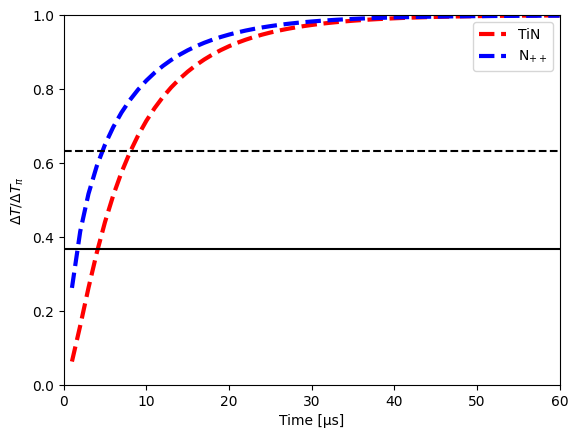

In [26]:
delta_T_pi = wvl0 / (2 * length * Si_dndT)

wg_t_time = wg_on_data.data[0].temperature.sel(x=0, z=0)
rib_t_time = rib_on_data.data[0].temperature.sel(x=0, z=0)

plt.plot(
    wg_t_time.t,
    (np.squeeze(wg_t_time.values) - ref_temp) / delta_T_pi,
    label="TiN",
    color="red",
    linewidth=3,
    linestyle="--",
)
plt.plot(
    rib_t_time.t,
    (np.squeeze(rib_t_time.values) - ref_temp) / delta_T_pi,
    label="N$_{++}$",
    color="blue",
    linewidth=3,
    linestyle="--",
)
plt.plot([0, heat_sim_time * 1e6], [1 - 1 / np.e, 1 - 1 / np.e], color="black", linestyle="--")
plt.plot([0, heat_sim_time * 1e6], [1 / np.e, 1 / np.e], color="black")
plt.legend()
plt.xlim(0, heat_sim_time * 1e6)
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(r"$\Delta T/\Delta T_\pi$")
plt.show()

To plot the temperature distribution through time, we can add an ipywidget slider to display the temperature distribution at various times.

In [27]:
import ipywidgets as widgets

times = np.linspace(0, 60, 61)

field_slider = widgets.FloatSlider(
    value=0,
    min=times[0],
    max=times[-1],
    step=None,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_wg_plot(x):
    if x not in times:
        x = min(times, key=lambda ll: abs(ll - x))
    wg_on_data["temperature"].temperature.sel(t=x, method="nearest").plot(
        grid=False, cmap="jet", vmax=np.max(wg_on_data["temperature"].temperature.values)
    )
    plt.xlim(-5, 5)
    plt.show()


widgets.interactive(update_wg_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.0, description='x', max=60.0, readout_format='.3f', step=None), Outp…

In [28]:
def update_rib_plot(x):
    if x not in times:
        x = min(times, key=lambda ll: abs(ll - x))
    rib_on_data["temperature"].temperature.sel(t=x, method="nearest").plot(
        grid=False, cmap="jet", vmax=np.max(rib_on_data["temperature"].temperature.values)
    )
    plt.xlim(-5, 5)
    plt.show()


widgets.interactive(update_rib_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.0, description='x', max=60.0, readout_format='.3f', step=None), Outp…

## Optical Mode Simulations

Using the temperature data of the steady-state heat simulations, we perturb the optical properties of the mediums in preparation for our optical simulations.

In [29]:
wg_perturbed_scene = wg_scene.perturbed_mediums_copy(temperature=wg_data["temperature"].temperature)

rib_perturbed_scene = rib_scene.perturbed_mediums_copy(
    temperature=rib_data["temperature"].temperature
)

For both waveguide structures, we will create a list of structures with only the perturbed optical mediums of the scene.

In [30]:
def get_optical_structures(scene):
    optical_structures = []
    for structure in scene.structures:
        optical_medium = structure.medium.optical
        if optical_medium is None:
            optical_medium = scene.medium.optical
        optical_structures.append(structure.updated_copy(medium=optical_medium))
    return optical_structures

Now we create optical simulations using the perturbed optical mediums.

In [31]:
optical_sim_size = (8, 0, 4)
optical_sim_center = (0, 0, 1)

wg_optic = td.Simulation(
    center=optical_sim_center,
    size=optical_sim_size,
    structures=get_optical_structures(wg_perturbed_scene),
    run_time=1e-15,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=50, wavelength=wvl0),
    medium=SiO2_perturb.perturbed_copy(temperature=wg_data["temperature"].temperature),
)

rib_optic = wg_optic.updated_copy(
    structures=get_optical_structures(rib_perturbed_scene),
    medium=SiO2_perturb.perturbed_copy(temperature=rib_data["temperature"].temperature),
)

We now construct the mode solving simulations for the perturbed mediums.

In [32]:
from tidy3d.plugins.mode import ModeSolver

mode_solver_plane = td.Box.from_bounds(rmin=(-5, 0, -1.5), rmax=(5, 0, 2))
mode_spec = td.ModeSpec(num_modes=1, precision="double")

wg_mode_solver = ModeSolver(
    simulation=wg_optic, plane=mode_solver_plane, mode_spec=mode_spec, freqs=[freq0]
)

rib_mode_solver = ModeSolver(
    simulation=rib_optic, plane=mode_solver_plane, mode_spec=mode_spec, freqs=[freq0]
)

We now run the mode solvers.

In [33]:
wg_mode_data = web.run(wg_mode_solver, task_name="wg mode", reduce_simulation=True)
rib_mode_data = web.run(rib_mode_solver, task_name="rib mode", reduce_simulation=True)

18:26:04 EDT Created task 'wg mode' with resource_id                            
             'mo-33483943-4b61-4565-bf99-ef9d2b364d7e' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=781813;https://tidy3d.simulation.cloud/workbench?taskId=mo-33483943-4b61-4565-bf99-ef9d2b364d7e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=309181;https://tidy3d.simulation.cloud/workbench?taskId=mo-33483943-4b61-4565-bf99-ef9d2b364d7e\taskId]8;;\]8;id=781813;https://tidy3d.simulation.cloud/workbench?taskId=mo-33483943-4b61-4565-bf99-ef9d2b364d7e\=]8;;\]8;id=93372;https://tidy3d.simulation.cloud/workbench?taskId=mo-33483943-4b61-4565-bf99-ef9d2b364d7e\mo]8;;\]8;id=781813;https://tidy3d.simulation.cloud/workbench?taskId=mo-33483943-4b61-4565-bf99-ef9d2b364d7e\-33483943-4b61-]8;;\
             ]8;id=781813;https://tidy3d.simulation.cloud/workbench?taskId=mo-33483943-4b61-4565-bf99-ef9d2b364d7e\4565-bf99-ef9d2b364d7e']8;;\.

             Task folder: ]8;id=559993;https://tidy3d.simulation.cloud/folders/folder-86acd7be-dbf5-477e-9c86-3e20787acc03\'default']8;;\.

Output()

18:26:05 EDT Estimated FlexCredit cost: 0.007. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:26:06 EDT status = success

Output()

18:26:08 EDT loading simulation from simulation_data.hdf5

             Created task 'rib mode' with resource_id                           
             'mo-8c498b17-8ac5-46cd-83e6-08c772c9c37f' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=577955;https://tidy3d.simulation.cloud/workbench?taskId=mo-8c498b17-8ac5-46cd-83e6-08c772c9c37f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=923698;https://tidy3d.simulation.cloud/workbench?taskId=mo-8c498b17-8ac5-46cd-83e6-08c772c9c37f\taskId]8;;\]8;id=577955;https://tidy3d.simulation.cloud/workbench?taskId=mo-8c498b17-8ac5-46cd-83e6-08c772c9c37f\=]8;;\]8;id=270579;https://tidy3d.simulation.cloud/workbench?taskId=mo-8c498b17-8ac5-46cd-83e6-08c772c9c37f\mo]8;;\]8;id=577955;https://tidy3d.simulation.cloud/workbench?taskId=mo-8c498b17-8ac5-46cd-83e6-08c772c9c37f\-8c498b17-8ac5-]8;;\
             ]8;id=577955;https://tidy3d.simulation.cloud/workbench?taskId=mo-8c498b17-8ac5-46cd-83e6-08c772c9c37f\46cd-83e6-08c772c9c37f']8;;\.

             Task folder: ]8;id=591395;https://tidy3d.simulation.cloud/folders/folder-86acd7be-dbf5-477e-9c86-3e20787acc03\'default']8;;\.

Output()

18:26:10 EDT Estimated FlexCredit cost: 0.005. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:26:11 EDT status = success

Output()

18:26:14 EDT loading simulation from simulation_data.hdf5

We plot the mode field profiles to ensure the mode solving was done correctly.

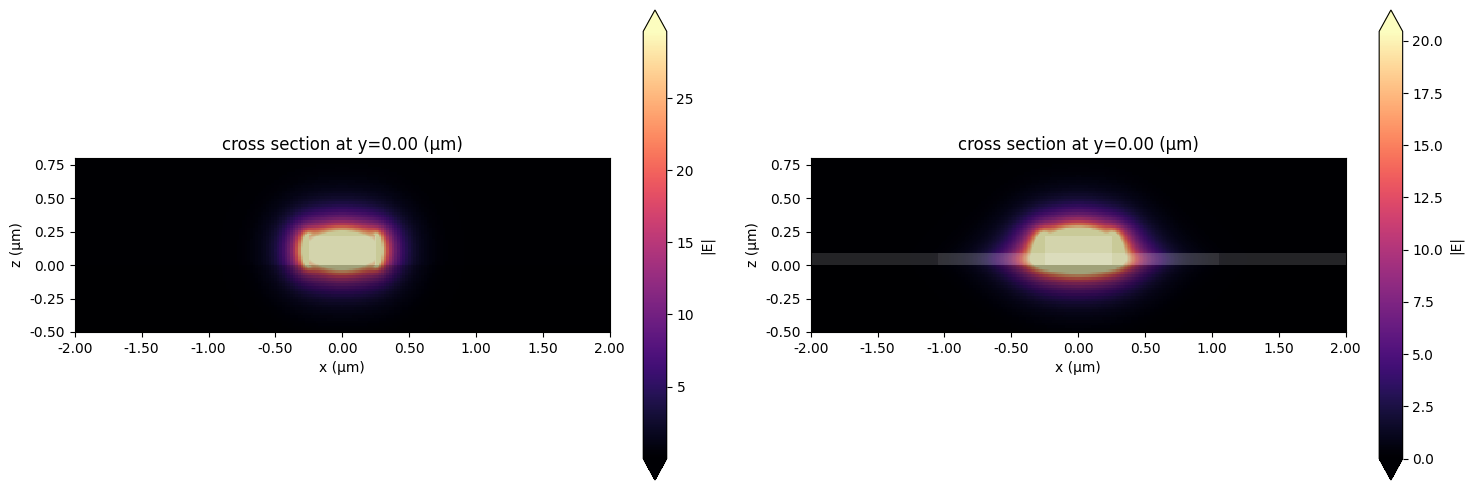

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

wg_mode_solver.plot_field(field_name="E", val="abs", ax=ax[0])
rib_mode_solver.plot_field(field_name="E", val="abs", ax=ax[1])
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-0.5, 0.8)
ax[1].set_xlim(-2, 2)
ax[1].set_ylim(-0.5, 0.8)
plt.tight_layout()
plt.show()

Finally we use the computed mode data to find the loss:

In [35]:
alpha_wg = wg_mode_data.modes_info["loss (dB/cm)"].item()
alpha_rib = rib_mode_data.modes_info["loss (dB/cm)"].item()

print(
    f"Attenuation: {alpha_wg} dB/cm for the strip waveguide and {round(alpha_rib, 3)} dB/cm for the rib waveguide."
)

Attenuation: 0.0 dB/cm for the strip waveguide and 0.315 dB/cm for the rib waveguide.
